In [6]:
from ipynb.fs.full.functions import getCancerPixels
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np
import os

In [7]:
def getPatientData():
    import scipy.io
    """
    Read the data from the stray .mat files and store it in a
    list of dictionaries, with each list element containing a patient
    e.g.
        patients = 
    
        1x104 list with each entry being a dict with fields:
        
            adc       | (144x144x26) ndarray uint16
            cdi       | (144x144x26) ndarray float64
            pMask     | (144x144x26) ndarray bool
            numTumor  | int
            patientID | str
            tumors    | dict
            
        patients[2]['tumors'] = 
        
        a dict with fields:
        
            gleasonScore | list of int
            lesion       | list of (144x144x26) ndarray bool
    
    """
    patientID = scipy.io.loadmat('../patientID.mat')['patientID']
    numPatients = len(patientID)

    patientIDWithTumor = scipy.io.loadmat('../posID.mat')['caseID']
    numPatientsWithTumor = len(patientIDWithTumor)
    
    patients = [dict() for x in range(numPatients)]
    
    for i in range(numPatients):
        path = "../100_original_anonymized_images_ExportedMatlab/" + patientID[i] + '/'
        patients[i] = {
            "adc": scipy.io.loadmat(path + 'ADC_' + patientID[i] + '.mat')['ADC'],
            "cdi": scipy.io.loadmat(path + 'CDI_matlab_' + patientID[i] + '.mat')['CDI_matlab'],
            "pMask": np.array(scipy.io.loadmat(path + 'PMask0_' + patientID[i] + '.mat')['Mask0'],dtype=bool),
            "numTumor": 0,
            "patientID": patientID[i]
        }
        lesionFilePath = path + 'Lesion_' + patientID[i] + '.mat'
        if os.path.exists(lesionFilePath):
            lesionData = scipy.io.loadmat(lesionFilePath)['Lesion']
            lesionInfo = scipy.io.loadmat(path + 'Lesion_info_' + patientID[i] + '.mat')['Lesion_info']
            patients[i]["numTumor"] = len(lesionInfo[0])
            patients[i]["tumors"] = {
                "gleasonScore": [lesionInfo[0][j] for j in range(len(lesionInfo[0]))],
                "lesion": [np.array(lesionData[0][j],dtype=bool) for j in range(len(lesionInfo[0]))]
            }
    return [patients, numPatients, numPatientsWithTumor]

In [8]:
def getCancerPixels(patient,modality,cancer):
    """
    Takes a patient dictionary as input and return an array that contains 
    all the pixels identified as either cancerous or non-cancerous
    @input: patient: a dictionary containing all relevant info about a patient
    @input modality: a string indicating adc or cdi
    @input: cancer: a bool indicating whether the pixels should be cancerous or not
    @output: an array containing all the identified pixels of the given modality
    """
    cancerMask = getCombinedCancerMask(patient, modality)
    try:
        return patient[modality][cancerMask==int(cancer)]
    except:
        print("Unrecognized modality.")
        return 0

def getCombinedCancerMask(patient, modality):
    if patient['numTumor'] == 0:
        return np.zeros(np.shape(patient[modality]))
    else:
        cancerMask = np.zeros(np.shape(patient[modality]), dtype=bool)
        for i in range(patient["numTumor"]):
            if patient["tumors"]["gleasonScore"][i] < 7:
                continue
            cancerMask[np.logical_or(cancerMask == 1,patient["tumors"]["lesion"][i] == 1)] = 1
    return cancerMask

In [9]:
def splitModalityPixel(training_set=None):
    assert type(training_set == "numpy.ndarray"), "The input parameter must be a numpy array"
    assert training_set.all() != None, "empty training set"
    assert  len(training_set) != 0, "empty training set"
    
    adcCancerPixels,    cdiCancerPixels    = np.array([]), np.array([])
    adcNonCancerPixels, cdiNonCancerPixels = np.array([]), np.array([])

    for patient in training_set:
        if patient["numTumor"] != 0:
            cancerPixelsTmp = getCancerPixels(patient,"adc",True)
            adcCancerPixels = np.append(adcCancerPixels, cancerPixelsTmp)
            cancerPixelsTmp = getCancerPixels(patient,"cdi",True)
            cdiCancerPixels = np.append(cdiCancerPixels, cancerPixelsTmp)
        nonCancerPixelsTmp = getCancerPixels(patient,"adc",False)
        adcNonCancerPixels = np.append(adcNonCancerPixels, nonCancerPixelsTmp)
        nonCancerPixelsTmp = getCancerPixels(patient,"cdi",False)
        cdiNonCancerPixels = np.append(cdiNonCancerPixels, nonCancerPixelsTmp)
    
    return adcCancerPixels, adcNonCancerPixels, cdiCancerPixels, cdiNonCancerPixels

In [10]:
# Get patients
[patients, numPatients, numPatientsWithTumor] = getPatientData()
patients = np.array([item for item in patients if item["patientID"] != "P00000249" and item["patientID"] != "P00000514" and item["patientID"] != "P00000654"])

In [14]:
# get pixels by modality and cancer
adcCancerPixels, adcNonCancerPixels, cdiCancerPixels, cdiNonCancerPixels = splitModalityPixel(patients)

(2061,)
(52750323,)
(2061,)
(52750323,)
0.0
65534.0
0.0
738.1567785245485


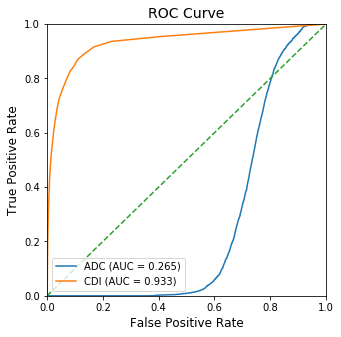

In [24]:
print(adcCancerPixels.shape)
print(adcNonCancerPixels.shape)
print(cdiCancerPixels.shape)
print(cdiNonCancerPixels.shape)
min_adc = min(min(adcCancerPixels), min(adcNonCancerPixels))
max_adc = max(max(adcCancerPixels), max(adcNonCancerPixels))
print(min_adc)
print(max_adc)
min_cdi = min(min(cdiCancerPixels), min(cdiNonCancerPixels))
max_cdi = max(max(cdiCancerPixels), max(cdiNonCancerPixels))
print(min_cdi)
print(max_cdi)
thresholds_adc = np.linspace(-0.9999, 3476.01, num=10000)
thresholds_cdi = np.linspace(-0.9999, 41.08, num=10000)
#thresholds_adc = np.linspace(-1, 3500, num=500)
#thresholds_cdi = np.linspace(-1, 42, num=500)

# get adc fprs and tprs
adc_fpr = []
adc_tpr = []

for threshold in thresholds_adc:
    adc_tpr.append(len(adcCancerPixels[adcCancerPixels < threshold])/ len(adcCancerPixels))
    adc_fpr.append(len(adcNonCancerPixels[adcNonCancerPixels < threshold])/len(adcNonCancerPixels))

cdi_fpr = []
cdi_tpr = []

for threshold in thresholds_cdi:
    cdi_tpr.append(len(cdiCancerPixels[cdiCancerPixels > threshold])/ len(cdiCancerPixels))
    cdi_fpr.append(len(cdiNonCancerPixels[cdiNonCancerPixels > threshold])/len(cdiNonCancerPixels))

from sklearn.metrics import auc
adc_auc = auc(adc_fpr, adc_tpr)
cdi_auc = auc(cdi_fpr, cdi_tpr)

plt.figure(figsize=(5,5))
plt.plot(adc_fpr, adc_tpr)
plt.plot(cdi_fpr, cdi_tpr)
plt.plot(adc_fpr, adc_fpr, "--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("ROC Curve", fontsize=14)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(["ADC (AUC = %.3f)"%adc_auc,"CDI (AUC = %.3f)"%cdi_auc], loc = "best")
plt.show()

In [32]:
# go through adc_tpr until 0.9 and 0.95 are hit
thres9a = -1
for i in range(len(adc_tpr)):
    if thres9a == -1 and adc_tpr[i] >= 0.9:
        thres9a = thresholds_adc[i]
        print(i)
        print(thres9a)
        print(adc_tpr[i])
        print(adc_fpr[i])
        break

3365
1169.1309444344436
0.9000485201358563
0.8461830082064142


In [34]:
thres9c = -1
for i in range(len(cdi_tpr)):
    if thres9c == -1 and cdi_tpr[len(cdi_tpr) - i - 1] >= 0.9:
        thres9c = thresholds_cdi[len(cdi_tpr) - i - 1]
        print(len(cdi_tpr) - i - 1)
        print(thres9c)
        print(cdi_tpr[len(cdi_tpr) - i - 1])
        print(cdi_fpr[len(cdi_tpr) - i - 1])
        break

240
0.01011860186018576
0.9155749636098981
0.16768447086096516


In [35]:
thres95a = -1
for i in range(len(adc_tpr)):
    if thres95a == -1 and adc_tpr[i] >= 0.95:
        thres95a = thresholds_adc[i]
        print(i)
        print(thres95a)
        print(adc_tpr[i])
        print(adc_fpr[i])
        break

3727
1295.011290849085
0.9500242600679282
0.8853226358443341


In [36]:
thres95c = -1
for i in range(len(cdi_tpr)):
    if thres95c == -1 and cdi_tpr[len(cdi_tpr) - i - 1] >= 0.95:
        thres95c = thresholds_cdi[len(cdi_tpr) - i - 1]
        print(len(cdi_tpr) - i - 1)
        print(thres95c)
        print(cdi_tpr[len(cdi_tpr) - i - 1])
        print(cdi_fpr[len(cdi_tpr) - i - 1])
        break

238
0.0017017801780176978
0.9534206695778749
0.40302111515032807
